In [155]:
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos

In [160]:
names = ['A','Bb','B','C','Db','D','Eb','E','F','Gb','G','Ab']
all_notes = {}
for i in range(120):
    all_notes[names[i%12] + str(i//12)] = (i, round(27.5*2**(i/12),4))
#Anything above A8 is not very musical
# https://www.szynalski.com/tone-generator/
N = {}
for i in range(96):
    N[names[i%12] + str(i//12)] = (i, round(27.5*2**(i/12),4))
# print(N)
Nk = list(N.keys())
# print(Nk)

In [161]:
def major(note):
    idx = names.index(note)
    steps = [0, 2, 4, 5, 7, 9, 11, 12]
    return [names[(idx + s)%12] for s in steps]

def natural_minor(note):
    idx = names.index(note)
    steps = [0, 2, 3, 5, 7, 8, 10, 12]
    return [names[(idx + s)%12] for s in steps]

def harmonic_minor(note):
    idx = names.index(note)
    steps = [0, 2, 3, 5, 7, 8, 11, 12]
    return [names[(idx + s)%12] for s in steps]

def major_chord(note):
    m = major_scale(note)
    return (m[0], m[2], m[4])

In [162]:
def gen_sin_wave(f, t, b = 2, s = 44100):
    #f = frequency of wave
    #t = amount of time to generate sample (in milliseconds)
    #s = samples per second
    #b = bytes per sample
    freq = (6.28318530718 * f)/(s)
    arr_len = int(s * (t/1000))
    scale = 2**((b * 8)-1)
    dom = np.arange(0, arr_len * freq, freq)
    return (scale * np.sin(dom)).astype(np.int64)
#     return np.array([int(scale * sin(freq * i)) for i in range(arr_len)])

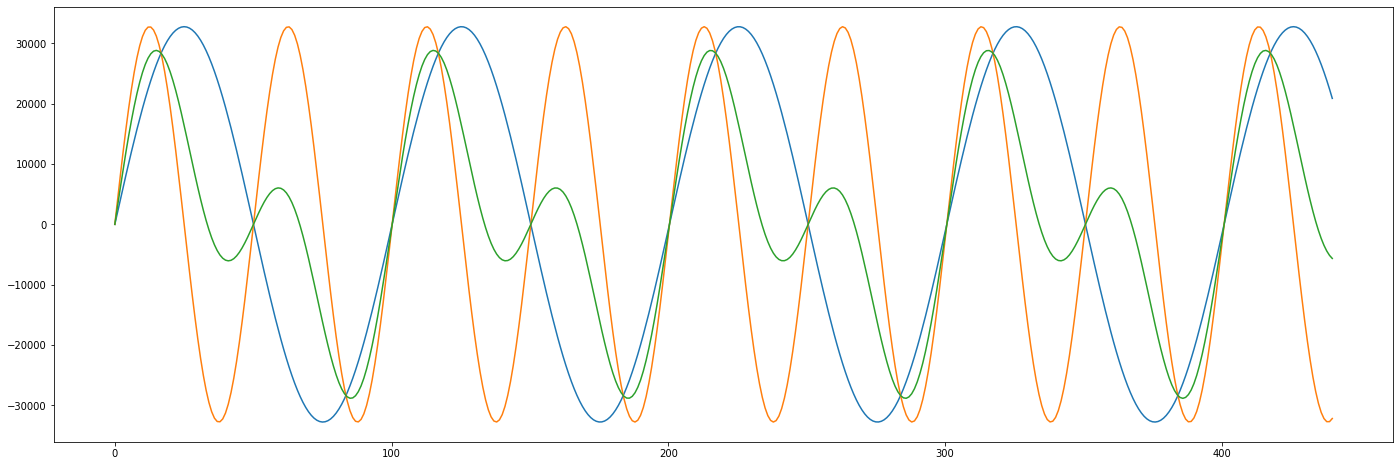

In [163]:
plt.figure(figsize=(24,8))
A4 = gen_sin_wave(N['A4'][1], 10)
plt.plot(A4)
A5 = gen_sin_wave(N['A5'][1], 10)
plt.plot(A5)
octave = (A4 + A5)//2
plt.plot(octave)

1323

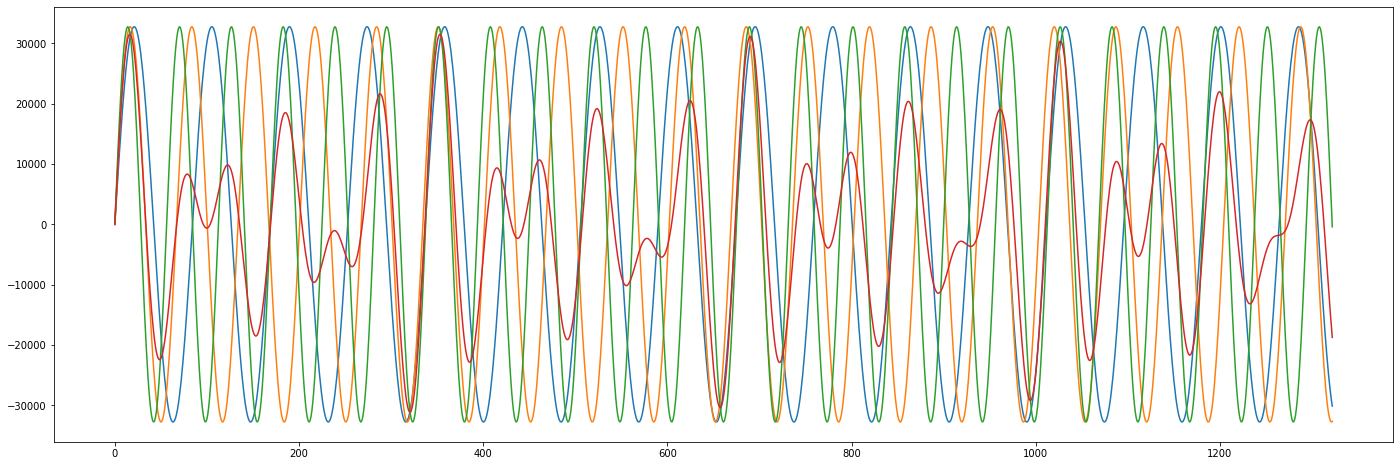

In [164]:
C = gen_sin_wave(N['C4'][1], 30)
E = gen_sin_wave(N['E4'][1], 30)
F = gen_sin_wave(N['F3'][1], 30)
G = gen_sin_wave(N['G4'][1], 30)
maj = (C + (E//2) + G)//2.5
fourth = (C + F)//2
plt.figure(figsize=(24,8))
plt.plot(C)
plt.plot(E)
plt.plot(G)
plt.plot(maj)
len(maj)

In [165]:
def dot_note(note, sample, s_rate=44100):
    l = len(sample)
    ret = 0
    reti = 0
    freq = (6.28318530718 * N[note][1])/s_rate
    for i in range(l):
        ret += sin(i * freq) * sample[i]
        reti += cos(i * freq) * sample[i]
    return (ret**2 + reti**2)

In [166]:
dot_note('G4', maj)

68450319999579.766

In [167]:
ifft = [dot_note(n, maj) for n in list(N.keys())]

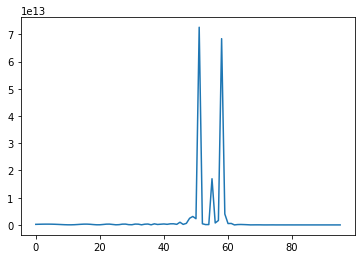

In [168]:
plt.plot(ifft)

In [174]:
maj = (C + E//2 + G)//2.5
maj2 = maj[157:]
maj2 += (np.random.rand(len(maj2)) * 32000).astype(np.int64)
maj2 = maj2.astype(np.int64)
len(maj2)

1166

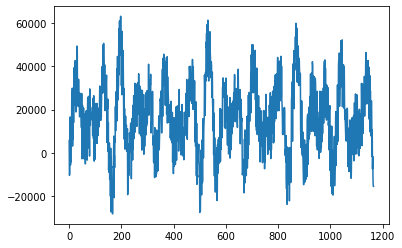

In [175]:
plt.plot(maj2)

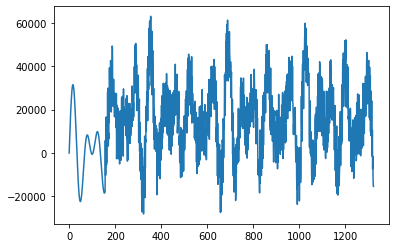

In [176]:
plt.plot(maj)

In [177]:
ifft = [int(dot_note(n, maj2)) for n in list(N.keys())[24:96]]

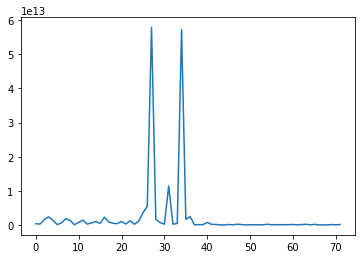

In [178]:
plt.plot(ifft)

In [179]:
#2048 samples * 96 frequencies* 2 values (sin, cos) * 8 bytes per float ~= 3MB

In [229]:
def parse_wav(b):
    assert b[0:4] == b'RIFF', "Chunk ID did not match 'RIFF'"
    chunk_size = int.from_bytes(b[4:8], byteorder="little")
    assert b[8:12] == b'WAVE', "Format did not match 'WAVE'"
    assert b[12:16] == b'fmt ', "Format subchunk ID did not match 'fmt '"
    chunk1_size = int.from_bytes(b[16:20], byteorder="little")
    audio_format = int.from_bytes(b[20:22], byteorder="little")
    assert audio_format == 1, "Audio Format is not PCM (i.e. data is compressed)"
    channels = int.from_bytes(b[22:24], byteorder="little")
    sample_rate = int.from_bytes(b[24:28], byteorder="little")
    byte_rate = int.from_bytes(b[28:32], byteorder="little")
    block_align = int.from_bytes(b[32:34], byteorder="little")
    bits_per_sample = int.from_bytes(b[34:36], "little")
    assert (bits_per_sample % 8) == 0 , "bits per sample is not a multiple of 8"
    assert (sample_rate * (bits_per_sample/8) * channels == byte_rate), "byte_rate != bytes_per_sample * sample_rate * num_channels"
    # from 36 onwards, we might have additional metadata
    data_idx = 36
    while True:
        temp_chunk_id = b[data_idx: data_idx + 4]
        temp_chunk_size = int.from_bytes(b[data_idx + 4: data_idx + 8], byteorder="little")
        if temp_chunk_id != b'data':
            data_idx += temp_chunk_size + 8 # add 8 to include the chunk_id and chunk_size fields
        else:
            break
            
    assert b[data_idx: data_idx + 4] == b'data', "Format subchunk ID did not match 'data'"
    sample_size = int.from_bytes(b[data_idx + 4: data_idx + 8], byteorder="little")
    sample_begin = data_idx + 8
    assert sample_size % block_align == 0, "size of sample in bytes is not divisible by number of bytes per sample"
    return {
        "File Size": chunk_size + 8,
        "Audio Format": "PCM",
        "Channels": channels,
        "Sample Rate": sample_rate,
        "Byte Rate": byte_rate,
        "Block Align (bytes per sample)": block_align,
        "Bits Per Sample Per Channel": bits_per_sample,
        "Samples Size": sample_size,
        "Num Samples": int(sample_size/block_align),
        "File Length (seconds)": round(sample_size/(byte_rate), 3),
        "Sample Beginning Index": sample_begin,
    }

In [260]:
f = open("sirduke.wav", "rb")
b = f.read()
f.close()
file_info = parse_wav(b)
file_info
# http://soundfile.sapp.org/doc/WaveFormat/

{'File Size': 20510798,
 'Audio Format': 'PCM',
 'Channels': 1,
 'Sample Rate': 44100,
 'Byte Rate': 88200,
 'Block Align (bytes per sample)': 2,
 'Bits Per Sample Per Channel': 16,
 'Samples Size': 20510720,
 'Num Samples': 10255360,
 'File Length (seconds)': 232.548,
 'Sample Beginning Index': 78}

In [264]:
ns = file_info['Num Samples']
lnl = ns if (ns%1024 == 0) else (1024 * (ns//1024 + 1))
nl = np.zeros(lnl, dtype=np.int16)
nl[:ns] = np.frombuffer(b[file_info['Sample Beginning Index']:], dtype='int16')
len(nl)

10255360

In [265]:
l = []
begin = file_info['Sample Beginning Index']
bytes_per_sample = file_info['Block Align (bytes per sample)']
end = file_info['Sample Beginning Index'] + file_info['Num Samples'] * bytes_per_sample

for i in range(begin, end, bytes_per_sample):
    l.append(int.from_bytes(b[i: i + 2], "little", signed=True))

if (len(l) % 1024 != 0):
    for i in range(1024 - (len(l)%1024)):
        l.append(0)

assert len(l)%1024 == 0, "not padded correctly"
print(len(l))

10255360


In [266]:
for i in range(len(nl)):
    assert nl[i] == l[i]

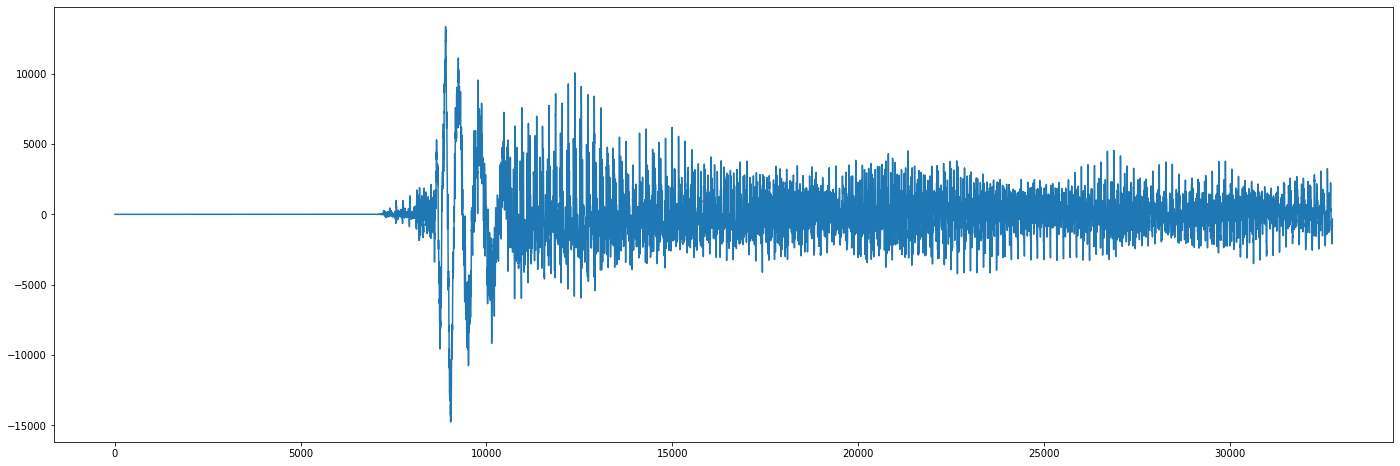

In [267]:
plt.figure(figsize=(24,8))
plt.plot(l[0:2**15])

In [269]:
#probably a faster way to do this
sample_len = 2048
sample_rate = 44100 #Hz

sinmat = np.zeros((96,sample_len))
cosmat = np.zeros((96,sample_len))
for i in range(96):
    freq = (6.28318530718 * N[Nk[i]][1])/sample_rate
    for j in range(sample_len):
        sinmat[i][j] = sin(j * freq)
        cosmat[i][j] = cos(j * freq)
    
numpsd = len(l)//1024 - 1
gabor = np.zeros((numpsd, 96))

#probably a faster way to do this as well
for i in range(numpsd):
    s = i * 1024
    e = s + 2048
    si = np.matmul(sinmat, l[s:e])
    ci = np.matmul(cosmat, l[s:e])
    psd = (si**2 + ci**2)
    gabor[i] = np.copy(psd)

gabor /= np.amax(gabor)

<BarContainer object of 96 artists>

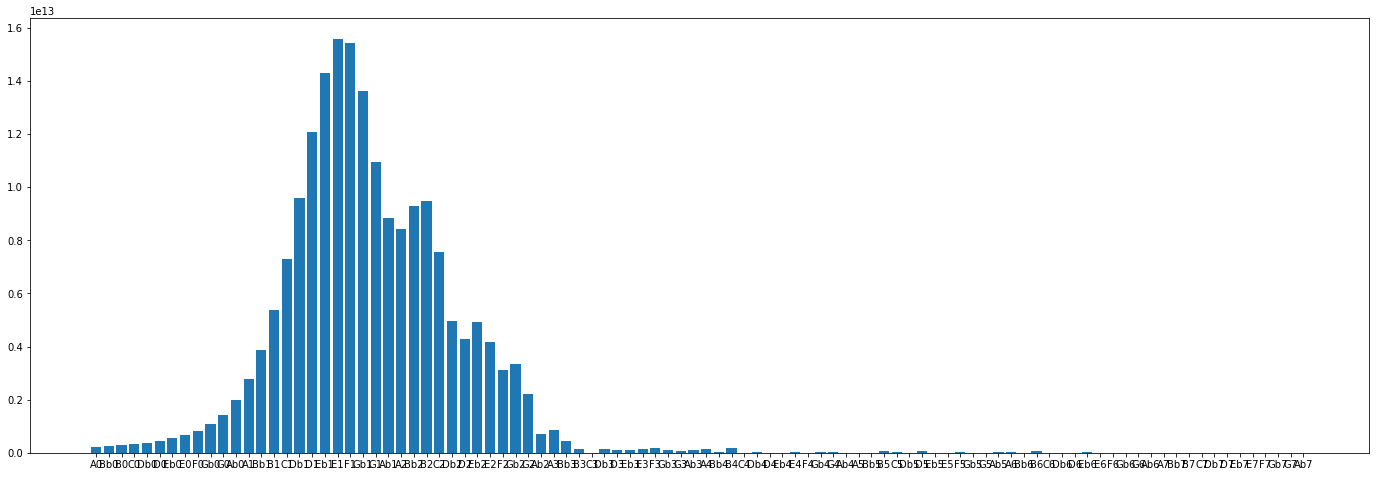

In [219]:
plt.figure(figsize=(24,8))
plt.bar(Nk, gabor[8])